<a href="https://colab.research.google.com/github/tomasallemand/wvs-democracy-attitudes-ml/blob/main/notebooks/01_wvs_democracy_attitudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Attitudes Toward Democracy  
World Values Survey – Machine Learning Project

# <mark style="background:#FFF9C4"> ABSTRACT

This project analyzes how people evaluate democracy using World Values Survey (WVS) responses.

The goal is to build a clean, reproducible pipeline that cleans survey data, explores key patterns, and trains a binary classification model to predict **lower vs higher ratings of democracy**, based on other individual attitudes and perceptions.

**Audience:** anyone interested in applied, end-to-end data analysis (EDA + modeling) using real survey data.

# <mark style="background:#FFF9C4"> PROJECT GOAL

Identify which survey variables are most associated with **Q250 (importance of democracy)** and build a predictive model that classifies respondents into **lower vs higher democracy ratings**, using only information available in the survey responses.

# <mark style="background:#FFF9C4"> ANALYTICAL CONTEXT

The dataset used in this project comes from the World Values Survey – Wave 7 (v5.0), a large-scale international survey covering over 200 questions related to socio-political and economic attitudes.

**The survey includes both**:
* Objective variables (e.g., age, income),
* Subjective perceptions (e.g., corruption, institutional trust, political values).

Although most variables are originally categorical, they are encoded as discrete numerical values in the dataset.

Each column is labeled using the format QXXX, where:
Q stands for "question",
The number identifies the specific survey item.

**The dataset contains**:
*  395 variables
* 1003 respondents

(The high dimensionality of the dataset makes it a suitable case for feature selection and regularized modeling techniques.)

In [42]:
!pip install catboost
!pip install shap
# Librerías:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
import plotly.express as px
import re
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    roc_auc_score
)
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from IPython.display import display
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

import shap
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", message="`js` is deprecated in `shap`.")

In [43]:
df=pd.read_csv('https://raw.githubusercontent.com/tomasallemand/wvs-democracy-attitudes-ml/main/data/WVS_FINAL_LIMPIO_7_v5.0.csv',delimiter=";")

In [44]:
df.head()

,version,doi,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,A_YEAR,D_INTERVIEW,J_INTDATE,FW_END,...,WEIGHT4A,WEIGHT4B,RESEMAVALBWGT,RESEMAVALWGT,SECVALBWGT,Y001_1,Y001_2,Y001_3,Y001_4,Y001_5
0,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070001.0,20170709.0,201707.0,...,1.0,1.0,0.83,0.915,1.00,0.0,0.0,0.0,0.0,0.0
1,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070002.0,20170709.0,201707.0,...,1.0,1.0,1.00,1.000,0.83,1.0,1.0,0.0,1.0,1.0
2,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070003.0,20170710.0,201707.0,...,1.0,1.0,1.00,1.000,1.00,0.0,0.0,1.0,0.0,0.0
3,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070004.0,20170710.0,201707.0,...,1.0,1.0,1.00,1.000,1.00,1.0,1.0,0.0,0.0,0.0
4,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070005.0,20170710.0,201707.0,...,1.0,1.0,1.00,1.000,1.00,1.0,1.0,0.0,1.0,0.0


In [45]:
# Drop duplicated columns:
columns_to_drop = ['Q34_3','Q33_3','Q35_3',]
df = df.drop(columns=columns_to_drop)

# <mark style="background:#FFF9C4"> DIMENSIONALITY REDUCTION

**About the data**:
Since this dataset comes from a survey, missing values are encoded as negative values rather than standard null entries.

Before EDA and modeling, negative values must be treated as missing observations and handled accordingly to ensure statistical consistency and avoid bias in the model

In [46]:
# Original dataset dimensionality:
df.shape

(1003, 392)

In [47]:
# Dimensionality reduction --> convert negative to Nan and drop empty cols.

# 1) Drop metadata cols: (We keep only Q* columns)
q_cols = [c for c in df.columns if re.fullmatch(r"Q\d+", str(c))]
df_model = df[q_cols].copy()

# 2) Cast everything to numeric
df_model = df_model.apply(pd.to_numeric, errors="coerce")

# 3) Negative responses to Nan
df_model = df_model.mask(df_model < 0, np.nan)

# 4) Empty cols:
all_nan_cols = df_model.columns[df_model.isna().all()].tolist()
print("100% NaN columns (to drop):", all_nan_cols)
df_model = df_model.drop(columns=all_nan_cols)

df_model.shape

100% NaN columns (to drop): []


(1003, 290)

# <mark style="background:#FFF9C4"> **EXPLORATORY DATA ANALYSIS**

The EDA focuses on a small set of variables for readability and interpretation.  
This subset is used for **visual exploration**, while the modeling pipeline can use a broader set of features after cleaning and preprocessing.

In [48]:
#Renombramos variables en aparencia más relevantes del dataset para crear visualizaciones más claras:
df_limpio = df_model.rename(columns={'Q250':'Importance_Democracy','Q243':'Trust_leaders','Q249':'Women_Man_EqualRights','Q112':'Corruption_Perception','Q237':'Army_Rule','Q197':'Government_rights','Q127':'Poor_inmigration','Q262':'Age'})

## **Univariate Analysis**:

### AGE (Q262):

In [49]:
# Histograma de distribución de la edad en la muestra:
px.histogram(df,x='Q262',title='AGE')

The age distribution is not uniform in this sample.  
This is relevant when interpreting results, since model performance reflects the observed sample composition.

The age distribution allows us to assess whether potential demographic biases might affect the interpretation of democratic attitudes.

### Importance of Democracy (Q250):

**We now examine the distribution of Q250 (Importance of Democracy), which serves as the target variable for the predictive model**:



In [50]:
df_limpio.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q281,Q282,Q283,Q284,Q285,Q286,Q287,Q288,Q289,Q290
0,1.0,2.0,4.0,4.0,1.0,4.0,1.0,2.0,1.0,1.0,...,6.0,NaN,NaN,1.0,1.0,2.0,3.0,5.0,1.0,32001.0
1,1.0,2.0,1.0,2.0,2.0,4.0,2.0,1.0,2.0,1.0,...,4.0,NaN,4.0,2.0,1.0,NaN,3.0,3.0,0.0,32001.0
2,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,6.0,NaN,7.0,2.0,1.0,NaN,3.0,5.0,1.0,32001.0
3,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,...,0.0,3.0,4.0,2.0,2.0,NaN,3.0,7.0,1.0,32001.0
4,1.0,1.0,1.0,3.0,1.0,3.0,1.0,2.0,2.0,1.0,...,4.0,NaN,4.0,2.0,1.0,4.0,3.0,4.0,1.0,32001.0


In [51]:
#Histograma de distribución de percepción de democracia (Variable dependiente):
px.histogram(df_limpio,x='Importance_Democracy',title='Importance of Democracy')

The distribution of Q250 is clearly left-skewed, with the majority of respondents concentrated at values 9 and 10. This is a common pattern in democracy-related survey items in countries with established democratic traditions - most people report that democracy matters to them.

This skew has direct implications for modeling: a regression approach would be heavily influenced by the high-end cluster, and a multi-class classification would face severe sparsity at lower values. Binarization is therefore both a practical and a theoretically motivated choice, as described in the Data Cleaning section.

In [52]:
# 'Q262' must be numeric
df_vis = df.copy()
df_vis['Q262'] = pd.to_numeric(df_vis['Q262'], errors='coerce')

# categories and bins
categories = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85']
bins = [18, 25, 35, 45, 55, 65, 75, 85]

# Aplicar pd.cut
df_vis['Q262'] = pd.cut(df_vis['Q262'], bins=bins, labels=categories, right=False)

# Convertir a categoría ordenada
df_vis['Q262'] = pd.Categorical(df_vis['Q262'], categories=categories, ordered=True)

In [53]:
# Crear el gráfico de cajas
fig = px.box(df_vis, x='Q262', y='Q250',
             title='Importance of democracy vs AGE',
             labels={'Q262': 'Age', 'Q250': 'Importance of democracy'},
             category_orders={'Q262': categories})


fig.update_layout(xaxis=dict(tickmode='array', tickvals=categories, ticktext=categories))

# Mostrar el gráfico
fig.show()

Despite initial assumptions, no strong age-related bias is observed in the perception of democracy within this sample.

## Bivariate Analysis:

### **Military Rule vs Democratic Valuation**:

In [54]:
# Gobierno militar contra importancia de la democracia:
fig = px.box(df_limpio, x='Army_Rule', y='Importance_Democracy', title='Democracy vs. Army Rule',
             category_orders={'Army_Rule': [1, 2, 3, 4],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Army_Rule': 'Army Rule', 'Importance_Democracy': 'Democracy'})

# Invertir el eje Y
fig.update_yaxes(categoryorder='array', categoryarray=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# Cambiar las etiquetas:
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

fig.update_xaxes(ticktext=['Suport_Army_Rule', '2', '3', 'Dont_Support_Army_Rule'],
                 tickvals=['1', '2', '3', '4'])

# Mostrar el gráfico
fig.show()

When grouping respondents according to their acceptance of a potential military government, clear distributional differences emerge.

Individuals who consider military rule acceptable show greater dispersion in their valuation of democracy.

In contrast, those who strongly reject military rule tend to assign consistently higher importance to democracy.

This pattern suggests an inverse relationship between support for authoritarian alternatives and democratic valuation.

### **Gender equality and Democracy**:

In [55]:
# Percepción de Género y valoración de la democracia:
fig = px.box(df_limpio, x='Women_Man_EqualRights', y='Importance_Democracy', title='Gender vs. Democratic Valuation')

# Cambiar las etiquetas:
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

fig.update_xaxes(ticktext=['Against_Equal_Rights','2', '3', '4', '5', '6', '7', '8', '9','Agree_with_equal_rights'],
                 tickvals=['1','2', '3', '4', '5', '6', '7', '8', '9', '10'])

# Mostrar el gráfico
fig.show()

The distribution of democracy importance ratings differs across responses to the question regarding gender equality.

This observation indicates a clear association within the sample, where individuals' perceptions of gender equality appear related to their valuation of democracy.

It is crucial to interpret this as a co-occurrence pattern within the dataset rather than a direct cause-and-effect relationship, as survey data primarily captures correlations.

### **Government Intrusion vs Democratic Valuation**:

In [56]:
# Crear el gráfico de cajas con las etiquetas personalizadas
fig = px.box(df_limpio,
             x='Government_rights',
             y='Importance_Democracy',
             title='Government Intrusion vs Democratic Valuation',
             category_orders={'Government_rights': ['Have the right', '2', '3', 'Not have the right'],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Government_rights': 'Government Intrusion',
                     'Importance_Democracy': 'Importance of Democracy'})

# Invertir el eje Y y cambiar las etiquetas
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Cambiar las etiquetas del eje X
fig.update_xaxes(ticktext=['Have the right', '2', '3', 'Not have the right'],
                 tickvals=[1, 2, 3, 4])

# Mostrar el gráfico
fig.show()

A similar distributional pattern is observed.

Respondents who reject state intrusion into private communications tend to show higher and more consistent democratic ratings.

Acceptance of broader state intervention is associated with greater heterogeneity in democratic valuation.

### **Trust in Free Elections vs Democratic Valuation**:

In [57]:
# Crear el gráfico de cajas con las etiquetas personalizadas
fig = px.box(df_limpio,
             x='Trust_leaders',
             y='Importance_Democracy',
             title='Trust in Free Elections vs Democratic Valuation',
             category_orders={'Trust_leaders': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Trust_leaders': 'Trust in Free Elections',
                     'Importance_Democracy': 'Importance of Democracy'})

# Invertir el eje Y y cambiar las etiquetas
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Cambiar las etiquetas del eje X
fig.update_xaxes(ticktext=['Dont_trust_free_elections', '2', '3', '4', '5', '6', '7', '8', '9', 'Trust_free_elections'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Mostrar el gráfico
fig.show()

Respondents who report higher trust in free and fair elections tend to assign greater importance to democracy as a political system.

The pattern is roughly monotonic: as trust in electoral processes increases, the median democracy rating rises and the dispersion narrows. This is consistent with the idea that institutional trust and democratic valuation reinforce each other.

### **Corruption Perception vs Democratic Valuation**:

In [58]:
# Crear el gráfico de cajas con las etiquetas personalizadas
fig = px.box(df_limpio,
             x='Corruption_Perception',
             y='Importance_Democracy',
             title='Corruption Perception vs Democratic Valuation',
             category_orders={'Corruption_Perception': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Corruption_Perception': 'Corruption Perception',
                     'Importance_Democracy': 'Importance of Democracy'})

# Invertir el eje Y y cambiar las etiquetas
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Cambiar las etiquetas del eje X
fig.update_xaxes(ticktext=['There is not Corruption', '2', '3', '4', '5', '6', '7', '8', '9', 'There is abundant Corruption'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Mostrar el gráfico
fig.show()

There is no such clear association between the assessment of democracy as a political regime and the perception of corruption.

### Correlation with target variable (Spearman)

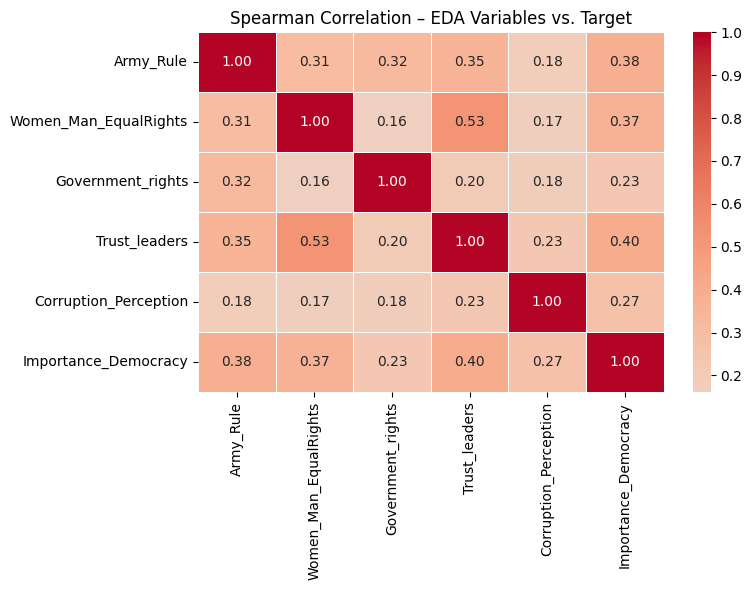

In [59]:
# Spearman correlation between EDA variables and the target
eda_vars = ['Army_Rule', 'Women_Man_EqualRights', 'Government_rights',
            'Trust_leaders', 'Corruption_Perception', 'Importance_Democracy']

corr_matrix = df_limpio[eda_vars].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            center=0, linewidths=0.5)
plt.title("Spearman Correlation – EDA Variables vs. Target")
plt.tight_layout()
plt.show()

The correlation matrix reveals several patterns worth highlighting before moving to the modeling stage.

**Army_Rule** shows the strongest correlation with democratic valuation (0.38), which is consistent with intuition: attitudes toward military government appear to be one of the clearest dividing lines in how people evaluate democracy as a system. **Trust_leaders** (trust in free elections) follows closely at 0.40, suggesting that institutional trust and democratic valuation tend to move together.

**Women_Man_EqualRights** also shows a meaningful association (0.37), reinforcing the pattern observed in the bivariate box plots. Notably, this variable also correlates moderately with Trust_leaders (0.53), which hints at an underlying attitudinal dimension linking egalitarian values with institutional confidence.

**Corruption_Perception** remains like one of the weakest correlate with the target (0.27), which is arguably the most interesting finding in this matrix. It suggests that perceiving widespread corruption does not necessarily translate into lower democratic valuation - people may still consider democracy important as a system even when they judge its current functioning harshly

These correlations informed the feature selection stage: variables with stronger associations to Q250 were more likely to be retained by SelectKBest.

# <mark style="background:#FFF9C4"> DATA CLEANING

- **Target (y):** Q250 (importance of democracy), converted to a binary label using a chosen threshold.
- **Features (X):** all remaining survey questions after cleaning and filtering

In [60]:
print("Top 15 columns with highest missing rate (before modeling):")
display((df_model.isna().mean().sort_values(ascending=False).head(15) * 100).to_frame("% NaN"))

Top 15 columns with highest missing rate (before modeling):


,% NaN
Q276,64.107677
Q282,64.107677
Q280,64.107677
Q89,41.475573
Q86,38.683948
Q87,35.194417
Q91,29.611167
Q88,25.523430
Q207,24.327019
Q283,24.127617


In [61]:
# =========================================================
# 1. Target y features
y_raw = df_model["Q250"].copy()

# keep only the rows where target is not missing
mask = y_raw.notna()
df_model = df_model.loc[mask].copy()
y_raw = y_raw.loc[mask].copy()

In [62]:
# Sorted distribution of Q250:
print("Q250 unique values:", sorted(y_raw.dropna().unique()))
print("Q250 value counts:\n", y_raw.value_counts(dropna=False).head(20))

vc = y_raw.dropna().value_counts().sort_index()
print("Q250 distribution (sorted)")
print(vc)

print("\nCumulative percentage:")
print((vc.cumsum() / vc.sum()).round(3))

Q250 unique values: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0)]
Q250 value counts:
 Q250
10.0    540
8.0     145
9.0     136
7.0      73
6.0      44
5.0      30
4.0      13
3.0       6
1.0       1
2.0       1
Name: count, dtype: int64
Q250 distribution (sorted)
Q250
1.0       1
2.0       1
3.0       6
4.0      13
5.0      30
6.0      44
7.0      73
8.0     145
9.0     136
10.0    540
Name: count, dtype: int64

Cumulative percentage:
Q250
1.0     0.001
2.0     0.002
3.0     0.008
4.0     0.021
5.0     0.052
6.0     0.096
7.0     0.170
8.0     0.316
9.0     0.454
10.0    1.000
Name: count, dtype: float64


### Target Variable: Binarization Strategy and Class Imbalance

Q250 is measured on a 1–10 scale. The distribution in this sample is strongly left-skewed — consistent with what political scientists typically find in surveys conducted in countries with historically rooted democratic values, where respondents tend to cluster at the higher end of the scale.

Given this skew, treating Q250 as a continuous or multi-class target would create severe sparsity in the lower range. The variable was therefore binarized using a threshold of 8: respondents scoring 1–8 are grouped as the "lower valuation" class (0), and those scoring 9–10 form the "higher valuation" class (1).

This threshold was chosen after examining the cumulative distribution of Q250: roughly 68% of valid responses fall above 8 (scores 9–10), creating a class imbalance of approximately 2:1 in favor of the higher-valuation class. To account for this, the `scale_pos_weight` hyperparameter was included in the XGBoost grid, and the `C` regularization parameter was tuned for Logistic Regression — both as mechanisms to handle class weighting during the search. The final selected model (Logistic Regression) manages this through its regularization.

It is worth noting that no threshold choice is entirely neutral in a context like this. The current approach prioritizes interpretability (a clear high/low distinction) while accounting for distributional realities in the data

In [63]:
THRESHOLD = 8
y = (y_raw > THRESHOLD).astype(int)

X = df_model.drop(columns=["Q250"]).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Class balance (train):\n", y_train.value_counts(normalize=True))

Train size: (791, 289) Test size: (198, 289)
Class balance (train):
 Q250
1    0.683944
0    0.316056
Name: proportion, dtype: float64


In [64]:
print(df_model['Q250'].value_counts())

Q250
10.0    540
8.0     145
9.0     136
7.0      73
6.0      44
5.0      30
4.0      13
3.0       6
1.0       1
2.0       1
Name: count, dtype: int64


# <mark style="background:#FFF9C4"> PREPROCESSOR:

The preprocessing pipeline applies:
- conversion of negative codes to missing values (NaN)
- imputation for missing values
- scaling (when required by the estimator)

All preprocessing is performed **inside the pipeline** to avoid data leakage.

In [65]:
def negative_to_nan(X):
    if isinstance(X, pd.DataFrame):
        X = X.copy()
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors="coerce")
        X = X.mask(X < 0, np.nan)
        return X
    else:
        X = X.copy()
        X[X < 0] = np.nan
        return X


In [66]:
numeric_features = list(X.columns)

preprocess = Pipeline(steps=[
    ("neg_to_nan", FunctionTransformer(negative_to_nan, feature_names_out="one-to-one")),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[("num", preprocess, numeric_features)],
    remainder="drop"
)

# Feature selection dentro del pipeline (evita leakage)
feature_selector = SelectKBest(score_func=f_classif, k=6)  # k acá lo dejamos como valor inicial, después buscamos el mejor en la grilla.

In [67]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('neg_to_nan',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function negative_to_nan at 0x79409cf98ae0>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7',
                                  'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14',
                                  'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
                                  'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26',
                                  'Q27', 'Q28', 'Q29', 'Q30', ...])])

# <mark style="background:#FFF9C4"> MODELING

We train and compare supervised classification models using cross-validation and a consistent preprocessing pipeline.

The goal is not only accuracy, but also a workflow that is reproducible and robust to missing survey responses.

##GridSearchCV:
Hyperparameter Optimization

In [68]:
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("select", feature_selector),
    ("estimator", LogisticRegression())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params_grid = [
    {
        "select__k": [4, 6, 8],
        "estimator": [LogisticRegression(max_iter=1000)],
        "estimator__C": [0.1, 1, 4, 10],
        "estimator__solver": ["liblinear"]
    },
    {
        "select__k": [4, 6, 8],
        "estimator": [RandomForestClassifier(random_state=42)],
        "estimator__n_estimators": [300, 500],
        "estimator__max_depth": [5, 7, 9]
    },
    {
        "select__k": [4, 6, 8],
        "estimator": [XGBClassifier(
            random_state=42,
            eval_metric="logloss",
            n_jobs=-1
        )],
        "estimator__n_estimators": [200, 300],
        "estimator__scale_pos_weight": [1, 2, 3], # class imbalance
        "estimator__max_depth": [3, 5],
        "estimator__learning_rate": [0.05, 0.1]
    },
    {
        "select__k": [4, 6, 8],
        "estimator": [CatBoostClassifier(
            random_state=42,
            verbose=0
        )],
        "estimator__iterations": [200, 300],
        "estimator__depth": [3, 5],
        "estimator__learning_rate": [0.05, 0.1]
    }
]

GS = GridSearchCV(
    estimator=pipe,
    param_grid=params_grid,
    cv=cv,
    scoring="f1",      # mejor que accuracy para clasificación binaria
    n_jobs=-1
)

GS.fit(X_train, y_train)

print("Best params:", GS.best_params_)
print("Best CV score (F1):", GS.best_score_)

Best params: {'estimator': LogisticRegression(max_iter=1000), 'estimator__C': 1, 'estimator__solver': 'liblinear', 'select__k': 6}
Best CV score (F1): 0.8415916527512051


In [69]:
best_model = GS.best_estimator_

# Baseline --> vemos si el modelo performa mejor que un nivel base:
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_test)

print("BASELINE accuracy:", accuracy_score(y_test, base_pred))
print("BASELINE F1:", f1_score(y_test, base_pred))

# Modelo final
y_pred = best_model.predict(X_test)

print("\nMODEL accuracy:", accuracy_score(y_test, y_pred))
print("MODEL F1:", f1_score(y_test, y_pred))

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# ROC-AUC (si el estimador tiene predict_proba)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
    print("MODEL ROC-AUC:", roc_auc_score(y_test, y_proba))

BASELINE accuracy: 0.6818181818181818
BASELINE F1: 0.8108108108108109

MODEL accuracy: 0.7727272727272727
MODEL F1: 0.8464163822525598

Confusion matrix:
 [[ 29  34]
 [ 11 124]]

Classification report:
               precision    recall  f1-score   support

           0       0.72      0.46      0.56        63
           1       0.78      0.92      0.85       135

    accuracy                           0.77       198
   macro avg       0.75      0.69      0.70       198
weighted avg       0.77      0.77      0.76       198

MODEL ROC-AUC: 0.7927689594356262


In [70]:
#el pipeline ganador
GS.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('neg_to_nan',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function negative_to_nan at 0x79409cf98ae0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Q1', 'Q2', 'Q3', 'Q4', 'Q5',
                                                   'Q6', 'Q7', 'Q8', 'Q9',
                                                   'Q10', 'Q11', 'Q12', 'Q13',
                                                   'Q14', 'Q15', 'Q16', 'Q17',
                                                   'Q18', 'Q19', 'Q20', 'Q21',
                                                   'Q22', 'Q23', 'Q24', 'Q25',
                                                   'Q26', 'Q27', 'Q28', 'Q29',
                                                   'Q30', ...])])),
                ('select', SelectKBest(k=6)),
                ('estimator',
                 LogisticRegression(C=1, max_iter=1000, solver='liblinear'))])

In [71]:
#Vemos los parámetros del modelo ganador:
GS.best_params_

{'estimator': LogisticRegression(max_iter=1000),
 'estimator__C': 1,
 'estimator__solver': 'liblinear',
 'select__k': 6}

In [72]:
#Guardamos el modelo final
modelo_final=GS.best_estimator_

In [73]:
modelo_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('neg_to_nan',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function negative_to_nan at 0x79409cf98ae0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Q1', 'Q2', 'Q3', 'Q4', 'Q5',
                                                   'Q6', 'Q7', 'Q8', 'Q9',
                                                   'Q10', 'Q11', 'Q12', 'Q13',
                                                   'Q14', 'Q15', 'Q16', 'Q17',
                                                   'Q18', 'Q19', 'Q20', 'Q21',
                                                   'Q22', 'Q23', 'Q24', 'Q25',
                                                   'Q26', 'Q27', 'Q28', 'Q29',
                                                   'Q30', ...])])),
                ('select', SelectKBest(k=6)),
                ('estimator',
                 LogisticRegression(C=1, max_iter=1000, solver='liblinear'))])

# <mark style="background:#FFF9C4"> FINAL MODEL

In [74]:
# Predicción:
print(f"Final score: {round(modelo_final.score(X_test,y_test),4)*100}%")

Final score: 77.27000000000001%


The final selected model is a **Logistic Regression** integrated within a preprocessing pipeline that includes:

* Missing value handling (negative values converted to NaN),
* Mode (most frequent value) imputation,
* Standard scaling,
* Univariate feature selection (SelectKBest).

After hyperparameter tuning through cross-validation, Logistic Regression achieved the best F1-score among the four evaluated models (Logistic Regression, Random Forest, XGBoost, CatBoost). This result is not surprising given the relatively small dataset size (n ≈ 989) and the linear separability that often emerges when the target variable is constructed from a threshold on a single ordinal item. Regularized linear models tend to generalize well in these conditions, often outperforming more complex ensembles.

The grid search optimized for F1-score rather than accuracy - a deliberate choice given the class imbalance (~2:1 in favor of class 1)-.

# <mark style="background:#FFF9C4">  EXPLAINABILITY

## Classification Report and Confusion Matrix

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.46      0.56        63
           1       0.78      0.92      0.85       135

    accuracy                           0.77       198
   macro avg       0.75      0.69      0.70       198
weighted avg       0.77      0.77      0.76       198



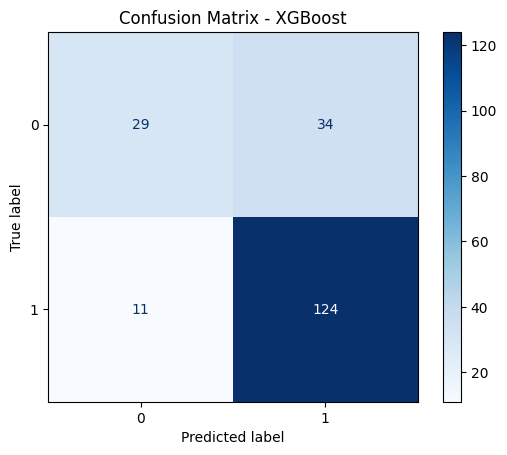

In [75]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [76]:
print("MODEL ROC-AUC:", roc_auc_score(y_test, y_proba))

MODEL ROC-AUC: 0.7927689594356262


Accuracy alone does not fully capture model performance here, given the class imbalance in the target variable. The classification report provides a more complete picture:

- **Class 0** (~32% of the data, lower democracy rating, scores 1–8)
- **Class 1** (~68% of the data, higher democracy rating, scores 9–10)

The Logistic Regression model shows solid performance on the majority class (class 1) and reasonable recall on the minority class (class 0), which is the harder group to detect. The ROC-AUC score of 0.792 confirms the model discriminates meaningfully between the two groups beyond chance.

The confusion matrix shows 29 true negatives and 124 true positives correctly classified, with 11 false negatives — cases where the model predicted lower valuation but the respondent actually scored 9 or 10.

## Feature importance

In [86]:
model_estimator = modelo_final.named_steps["estimator"]

# Check the type of the estimator to get appropriate feature importance
if hasattr(model_estimator, 'feature_importances_'):
    importances = model_estimator.feature_importances_
elif hasattr(model_estimator, 'coef_'):
    # For linear models, coefficients represent feature importance
    # Take absolute value for importance, as sign indicates direction
    importances = np.abs(model_estimator.coef_[0]) # [0] for binary classification
else:
    print("Estimator has no 'feature_importances_' or 'coef_' attribute for importance.")
    importances = []

feature_names = modelo_final.named_steps["select"].get_feature_names_out()

if importances.size > 0:
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    print("Top 15 features by importance (or coefficients for Logistic Regression):")
    display(importance_df.head(15))
else:
    print("No feature importances to display.")

Top 15 features by importance (or coefficients for Logistic Regression):


,feature,importance
3,x237,0.572007
2,x236,0.402084
0,x180,0.328602
4,x242,0.278572
5,x244,0.204193
1,x188,0.153445


In [88]:
q_code_to_name = {
    'Q250': 'Importance_Democracy', # Target variable (for reference)
    'Q243': 'Trust_leaders', # From df_limpio rename
    'Q249': 'Women_Man_EqualRights', # From df_limpio rename
    'Q112': 'Corruption_Perception', # From df_limpio rename
    'Q237': 'Army_Rule', # From df_limpio rename
    'Q197': 'Government_rights', # From df_limpio rename
    'Q127': 'Poor_inmigration', # From df_limpio rename
    'Q262': 'Age', # From df_limpio rename
    # Previously identified important features from the original feature_importances:
    'Q180': 'Justifiable: Cheating on taxes',
    'Q188': 'Justifiable: Euthanasia',
    'Q236': 'Technocracy_Preference',
    'Q242': 'Religious_Laws_As_Democracy',
    'Q244': 'Democracy: People receive state aid for unemployment',

    # Other features once identified by SelectKBest for SHAP:
    'Q189': 'Justifiable: For a man to beat his wife',
    'Q238': 'Having a democratic political system'
}


In [89]:
feature_names_cleaned = [f.replace('x', 'Q') for f in feature_names]

importance_df_renamed = pd.DataFrame({
    "feature": feature_names_cleaned,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Map QXXX codes to descriptive names
importance_df_renamed["feature_description"] = importance_df_renamed["feature"].map(q_code_to_name)

# Top 15 features and their importances
print("Top 15 features with descriptive names:")
display(importance_df_renamed[['feature_description', 'importance']].head(15))

Top 15 features with descriptive names:


,feature_description,importance
3,Army_Rule,0.572007
2,Technocracy_Preference,0.402084
0,Justifiable: Cheating on taxes,0.328602
4,Religious_Laws_As_Democracy,0.278572
5,Democracy: People receive state aid for unempl...,0.204193
1,Justifiable: Euthanasia,0.153445


To understand which variables most influence predictions, we extracted the absolute coefficient values from the trained Logistic Regression model. Unlike tree-based importance scores, logistic regression coefficients reflect the linear contribution of each feature to the log-odds of the prediction, after scaling — so they are directly comparable across features.

The most influential features selected by the model are:

- Army_Rule (Q237): attitude toward military government (1=Very good, 4=Very bad)
- Technocracy_Preference (Q236): attitude toward expert-led, non-electoral government (1=Very good, 4=Very bad)
- Religious_Laws_As_Democracy (Q242): how essential religious authorities interpreting the laws is as a characteristic of democracy (1=Not essential, 10=Essential)
- Euthanasia_Justifiable (Q188): whether euthanasia is considered justifiable (1=Never, 10=Always)

The relative importance of these features is shown in the output above. Army_Rule consistently emerges as a strong predictor, reinforcing the pattern identified in the EDA. The presence of Euthanasia_Justifiable and Religious_Laws_As_Democracy reflects the model's data-driven selection — these variables carry statistically meaningful signal in this sample even if the theoretical connection to democratic valuation is less direct.

## SHAP

SHAP (SHapley Additive exPlanations) values allow us to understand not just *which* features the model uses, but *how* and *in which direction* each feature influences individual predictions.

Unlike standard feature importance scores, SHAP provides a consistent, theoretically grounded measure of contribution - one that works at both the global (average across all predictions) and local (individual prediction) level. The analysis below includes a global bar plot, a beeswarm plot showing directional effects, and three individual force plots that trace how each feature contributes to specific predictions.

In [97]:
# Logistic Regression coefficients — sign indicates direction toward class 1
coef_df = pd.DataFrame({
    'feature': [q_code_to_name.get(f.replace('x','Q'), f.replace('x','Q'))
                for f in modelo_final.named_steps['select'].get_feature_names_out()],
    'coefficient': modelo_final.named_steps['estimator'].coef_[0]
}).sort_values('coefficient', ascending=False)

print("Coefficients (positive = pushes toward class 1 / high democracy):")
display(coef_df)

Coefficients (positive = pushes toward class 1 / high democracy):


,feature,coefficient
2,Technocracy_Preference,0.402084
4,Religious_Laws_As_Democracy,0.278572
1,Justifiable: Euthanasia,-0.153445
5,Democracy: People receive state aid for unempl...,-0.204193
0,Justifiable: Cheating on taxes,-0.328602
3,Army_Rule,-0.572007


In [98]:
# Extract pipeline components
lr_model = modelo_final.named_steps["estimator"]
preprocessor_step = modelo_final.named_steps["preprocessor"]
feature_selector_step = modelo_final.named_steps["select"]

# Apply preprocessor (transform only, no refit)
X_train_preprocessed = preprocessor_step.fit_transform(X_train)
X_test_preprocessed = preprocessor_step.transform(X_test)

preprocessed_feature_names = preprocessor_step.named_transformers_['num'].get_feature_names_out()

X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=preprocessed_feature_names, index=X_train.index)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=preprocessed_feature_names, index=X_test.index)

# Apply feature selector (already fitted inside the pipeline)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_train_selected_np = feature_selector_step.transform(X_train_preprocessed_df)
    X_test_selected_np = feature_selector_step.transform(X_test_preprocessed_df)

# Recover selected feature names
final_selected_q_codes = [f.replace('x', 'Q') for f in feature_names]

X_train_selected = pd.DataFrame(X_train_selected_np, columns=final_selected_q_codes, index=X_train.index)
X_test_selected = pd.DataFrame(X_test_selected_np, columns=final_selected_q_codes, index=X_test.index)

# Compute SHAP values using LinearExplainer (appropriate for Logistic Regression)
# LinearExplainer for binary classifiers can return values oriented toward class 0.
# We verify orientation using Q237 (Army_Rule): high values = anti-military = more democratic.
# If corr(Q237, SHAP_Q237) is negative, values are oriented toward class 0 and we invert.
explainer = shap.LinearExplainer(lr_model, X_train_selected)
shap_values_raw = explainer.shap_values(X_test_selected)

# Verify orientation using Technocracy_Preference (Q236): coef is positive in this model,
# so high values should have positive SHAP (corr > 0). If negative, values are inverted.
verify_col = 'Q236'
verify_idx = list(X_test_selected.columns).index(verify_col)
raw_corr = float(pd.Series(X_test_selected[verify_col].values).corr(
    pd.Series(shap_values_raw[:, verify_idx])))

if raw_corr < 0:
    # SHAP oriented toward class 0 — invert to orient toward class 1
    shap_values_test = -shap_values_raw
    expected_value_plot = -explainer.expected_value
else:
    shap_values_test = shap_values_raw
    expected_value_plot = explainer.expected_value

# Positive SHAP = pushes toward class 1 (high democracy valuation, scores 9-10).
# Feature display names for plots
selected_feature_names_list = final_selected_q_codes
mapped_feature_names_for_plot = [q_code_to_name.get(f, f) for f in selected_feature_names_list]

SHAP Summary Plot


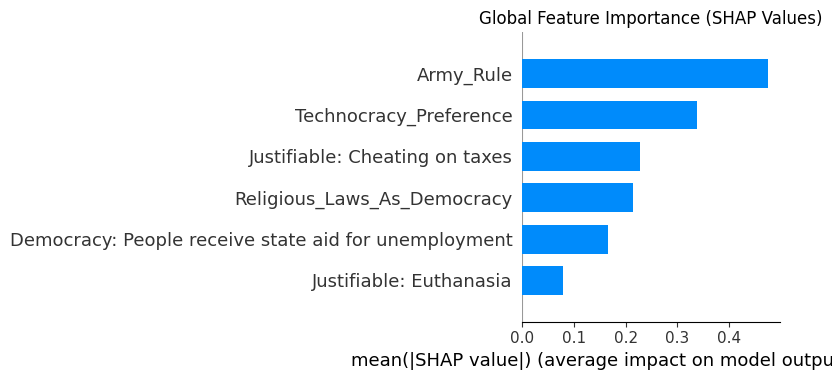

SHAP Beeswarm Plot


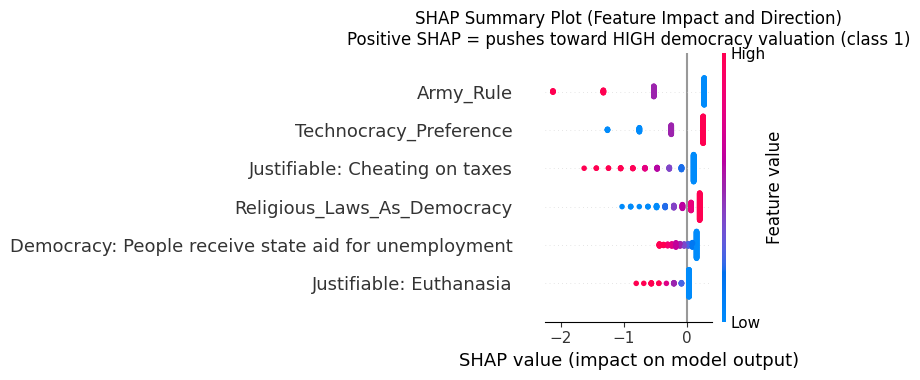

SHAP Force Plots for individual predictions
Force plot for test instance 0:


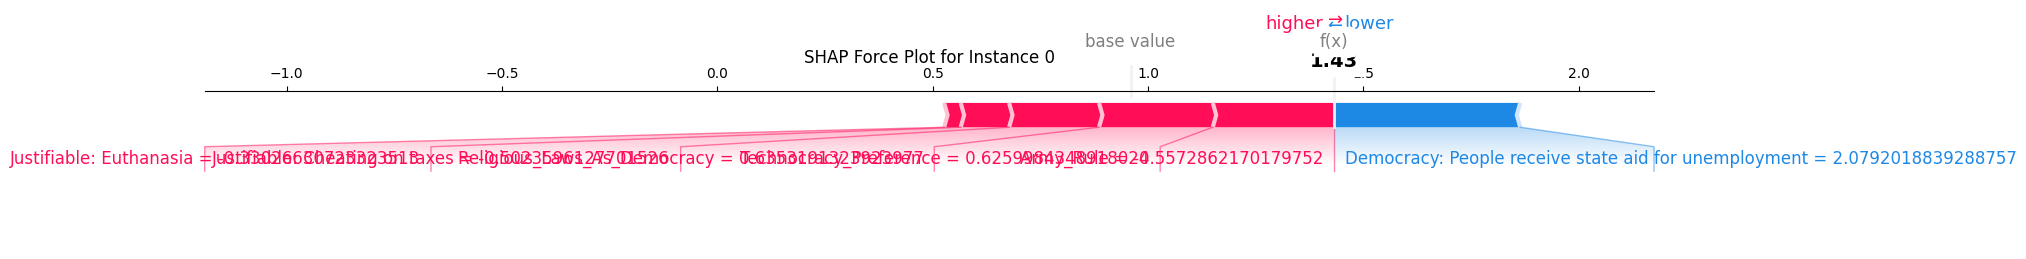

Force plot for test instance 1:


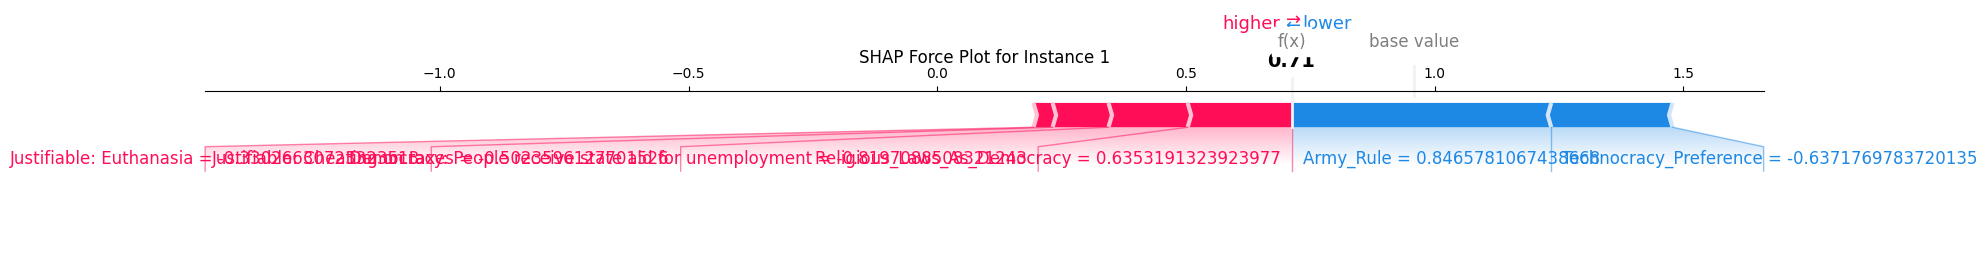

Force plot for test instance 2:


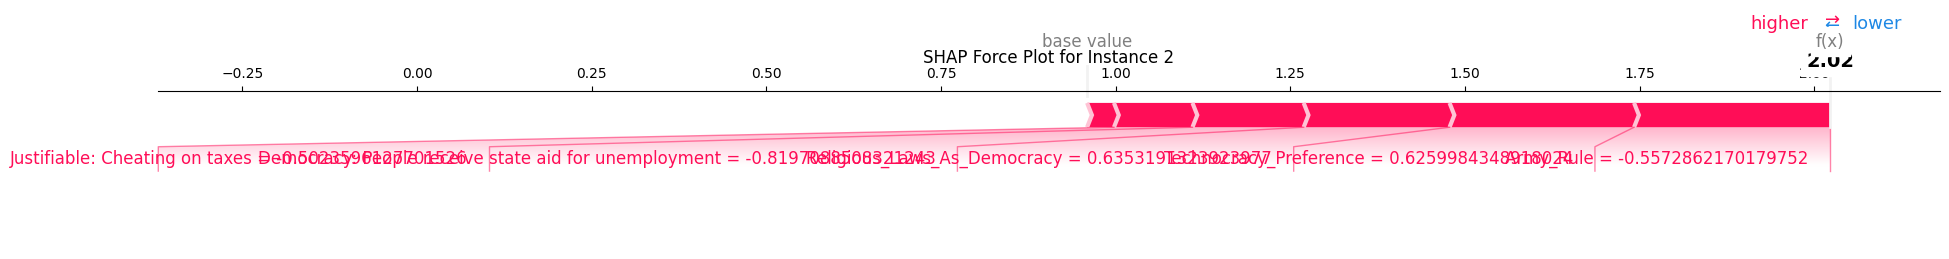

In [100]:
# Nombres descriptivos para los gráficos (en el orden de las columnas)
display_names = [q_code_to_name.get(col, col) for col in X_test_selected.columns]

# --- GRÁFICO 1: Bar plot (importancia global) ---
print("SHAP Summary Plot")
shap.summary_plot(shap_values_test, X_test_selected,
                  feature_names=display_names,
                  plot_type="bar",
                  show=False)
plt.title("Global Feature Importance (SHAP Values)")
plt.tight_layout()
plt.show()
plt.close()

# --- GRÁFICO 2: Beeswarm plot (dirección e impacto) ---
print("SHAP Beeswarm Plot")
shap.summary_plot(shap_values_test, X_test_selected,
                  feature_names=display_names,
                  show=False)
plt.title("SHAP Summary Plot (Feature Impact and Direction)\nPositive SHAP = pushes toward HIGH democracy valuation (class 1)")
plt.tight_layout()
plt.show()
plt.close()

# --- GRÁFICO 3: Force plots para 3 instancias individuales ---
print("SHAP Force Plots for individual predictions")

for i in range(3):
    print(f"Force plot for test instance {i}:")
    fig = shap.force_plot(
        expected_value_plot,
        shap_values_test[i],
        X_test_selected.iloc[i],
        feature_names=display_names,
        matplotlib=True,
        show=False
    )
    plt.title(f"SHAP Force Plot for Instance {i}", fontsize=12, pad=20)
    plt.tight_layout()
    plt.show()
    plt.close()

References:
- **Army_Rule (Q237)**: attitude toward military government (1=Very good // 4=Very bad)
- **Technocracy_Preference (Q236)**: attitude toward expert-led, non-electoral government (1=Very good // 4=Very bad)
- **Justifiable: Cheating on taxes (Q180)**: whether evading taxes is considered justifiable (1=Never // 10=Always)
- **Religious_Laws_As_Democracy (Q242)**: how essential it is that religious authorities interpret the laws as a characteristic of democracy (1=Not essential // 10=Essential)
- **Democracy: People receive state aid for unemployment (Q244)**: how essential state welfare is as a characteristic of democracy (1=Not essential // 10=Essential)
- **Justifiable: Euthanasia (Q188)**: whether euthanasia is considered justifiable (1=Never // 10=Always)

### SHAP Interpretation

**Global importance (bar plot)**

Army_Rule is the dominant predictor by a wide margin. The selected features span different attitudinal domains — political system preferences, views on religion and governance, and moral attitudes — but together they capture meaningful variation in how respondents value democracy.

**Directionality (beeswarm plot)**

The beeswarm shows the direction each feature pushes predictions *as learned jointly by the model*. Due to statistical suppression between correlated features, some directions differ from the raw univariate correlations seen in the EDA. This is expected behavior in multivariate regression and does not indicate a modeling error — it reflects how the model redistributes predictive weight across correlated variables.

- **Army_Rule (Q237)**: in the multivariate model, respondents with high values (rejecting military rule, 3–4) show **negative** SHAP values, pushed toward lower predicted democratic valuation. **This is a suppression effect: Army_Rule shares variance with Technocracy_Preference, and the model assigns the positive predictive weight to Technocracy while Army_Rule captures a different dimension of the signal**. Despite the counterintuitive direction, its absolute coefficient (0.57) confirms it as the dominant predictor in terms of magnitude.

- **Technocracy_Preference (Q236)**: the primary positive predictor in this model. Respondents with high values — those who consider expert-led non-electoral government *fairly bad* or *very bad* (3–4) — are pushed toward higher democratic valuation. In the context of suppression, this variable absorbs much of the pro-democracy signal that Army_Rule carries in univariate analysis.

- **Justifiable: Cheating on taxes (Q180)**: respondents who consider tax evasion more justifiable (high values, rosados) are pushed toward lower predicted democratic valuation — consistent with a civic norm interpretation: those who reject civic obligations tend to value democratic institutions less.

- **Religious_Laws_As_Democracy (Q242)**: respondents who consider religious authorities interpreting the laws *more* essential to democracy (high values) are pushed toward higher predicted democratic valuation in this model. This is a suppression effect — the univariate correlation is negative (−0.20), but in the multivariate context this variable captures a different attitudinal dimension.

- **Democracy: People receive state aid for unemployment (Q244)**: respondents who consider welfare *more* essential to democracy (high values) are pushed toward lower predicted democratic valuation in this model — another suppression effect. Univariately this variable correlates positively (+0.23) with the target, but in the joint model it plays a different role.

- **Justifiable: Euthanasia (Q188)**: respondents who find euthanasia more justifiable (high values) are pushed toward lower predicted democratic valuation. This is the weakest predictor (absolute coef 0.15) and its univariate correlation with the target is near zero (−0.04), so this direction should be treated as a fragile, sample-specific signal.

**Individual predictions (force plots)**

The three force plots illustrate how these features combine at the individual level. In these plots, **pink/red arrows push toward lower democratic valuation (class 0)** and **blue arrows push toward higher democratic valuation (class 1)**.

- **Instance 0**: a borderline prediction landing close to the decision boundary. Some features push toward higher valuation while others pull in the opposite direction — this respondent's profile contains genuinely mixed signals.
- **Instance 1**: an interesting case where not all features agree. One or more features push toward higher democratic valuation, but the remaining features push toward lower with enough combined weight to tip the final prediction toward class 0. A clear example of how the aggregate of features can override a single feature's contribution.
- **Instance 2**: the most unambiguous prediction in this set. Features align in the same direction, and the model assigns this respondent with higher confidence than the previous two cases.

#<mark style="background:#FFF9C4"> LIMITATIONS

- The analysis is observational and does not establish causal relationships.
- Survey responses may contain measurement bias.
- Cultural and country-level heterogeneity is not fully modeled in this version.
- Results depend on the chosen feature set and preprocessing decisions.

Future iterations could incorporate country fixed effects, multilevel modeling, or more advanced ensemble methods.

# <mark style="background:#FFF9C4"> MODEL SAVING

In [96]:
from joblib import dump
dump(modelo_final, "modelo_final_wvs.joblib", compress=("gzip", 9))

['modelo_final_wvs.joblib']